# Darts
Is a library that helps with time series prediction and may help the workflow a lot

In [128]:
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mape
from darts import concatenate

# Data Processing Tools
import numpy as np
import pandas as pd

import feature_generation as feat_gen
import data_processing as dat_proc
from darts.models import CatBoostModel



In [129]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')


In [130]:
X_train_estimated_a = X_train_estimated_a.drop("date_calc", axis = 1)

X = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)

# Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
X = X.interpolate(method='linear')
X = X.bfill()

# Extract necesarry values for feature generation.
timestamps = "date_forecast"
measurements = list(X.columns.values)
measurements.remove(timestamps)

# Probable features that may be used
der_df = feat_gen.difference_df(X, timestamps, measurements)
dder_df = feat_gen.double_derivative_from_df(X, timestamps, measurements)
int_df = feat_gen.daily_accumulated_val_df(X, timestamps, measurements)
dint_df = feat_gen.daily_accumulated_val_squared_df(X, timestamps, measurements)
time_df = feat_gen.time_data_from_df(X, timestamps)


X = pd.concat([X, der_df, dder_df, int_df, dint_df, time_df], axis = "columns")

y = train_a.dropna()

# Making sure that the two dataframes match in length.
y, X = dat_proc.data_length_matching(y, X)

# Get our desired output
y = y.reset_index(drop = True)


# Removing datetime object column
X = X.reset_index(drop = True)

c:\Users\isakasa\OneDrive - NTNU\Documents\UNI\TDT4173 Machine Learning\group-project\TDT4173-Machine-Learning-Solar-Energy-Production-Forecasting\data\feature_generation.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dder_df = dder_df.fillna(method="backfill", axis=None)


In [131]:
# Assuming 'train_series' is your training time series data
y_series = TimeSeries.from_dataframe(y, time_col="time", value_cols="pv_measurement", freq ="H", fill_missing_dates = False)
train_series, test_series = y_series.split_before(0.80)

def covariates_from_df(df: pd.DataFrame, timestamps: str, cols: list[str], freq: str) -> list[TimeSeries]:
    covariates = []
    for col in  cols:
        covariates.append(TimeSeries.from_dataframe(df, timestamps, col, freq = freq, fill_missing_dates = False))

    return covariates

def split_covariates(covariates: list[TimeSeries], size: float) -> tuple[TimeSeries]:
    train_covariates = []
    test_covariates = []

    for cov in covariates:
        train_cov, test_cov= cov.split_before(size)
        train_covariates.append(train_cov)
        test_covariates.append(test_cov)

    return train_covariates, test_covariates

def stack_series(series, covariates):
    
    stacked_series = series

    for cov in covariates:

        stacked_series = stacked_series.stack(cov)
    
    return stacked_series

# Sorting out covariates
best_cols = ["sun_elevation:d","direct_rad:W", "clear_sky_energy_1h:J", "is_in_shadow:idx", "total_cloud_cover:p"]
timestamps = "date_forecast"
freq = "H"

covariates = covariates_from_df(X, timestamps, best_cols, freq)
#train_covariates, test_covariates = split_covariates(covariates, size=0.8)

# train_series_with_covariates = stack_series(train_series, train_covariates)
# test_series_with_covariates = stack_series(test_series, test_covariates)



c:\Users\isakasa\AppData\Local\anaconda3\envs\basic_machine_learning\Lib\site-packages\darts\timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
c:\Users\isakasa\AppData\Local\anaconda3\envs\basic_machine_learning\Lib\site-packages\darts\timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime

In [132]:


forecast_horizon = 1
lags = 24

model = LinearRegressionModel(lags = 24, output_chunk_length = forecast_horizon, lags_future_covariates = [1])

In [133]:
# Assuming 'test_series' is your test time series data
# This is where things get strange...
model.fit(train_series, future_covariates = concatenate(covariates, axis = 1))

# This is where everything
predicted_series = model.predict(2100)

# It seems to add a lot of blockers due to the arithmatic provided, but I just think the library sort of sucks :/

#error = mape(test_series, predicted_series)
predicted_series.plot()

# error = mape(test_series, predicted_series)
# print(f'MAPE: {error}')

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: xlabel='time'>

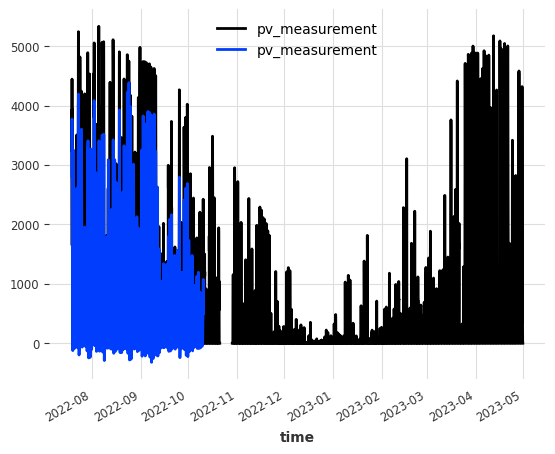

In [ ]:
test_series.plot()
predicted_series.plot()